In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
## Matplotlib settings
## inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 300,  # to adjust notebook inline plot size
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.5, 2.625], # 4 x 3
#     'figure.figsize': [4*1.125, 3*1.125], # 4x3, full slide in keynote
    'font.family': 'serif',
    'figure.max_open_warning':100
}
mpl.rcParams.update(params)

## Get physical constants from Scipy
import scipy.constants as con
## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
k = con.physical_constants['Boltzmann constant in eV/K'][0]

import scipy.integrate as int

import scipy.io as sio

import scipy.optimize as opt

In [3]:
misloc_pack_path = os.path.join(
    os.path.sep,
    'Users',
    'chair',
    'Documents',
    'Academia',
    'SuperRes',
    'Biteen_colab',
    'Mispolarization',
    'python',
    'gitted',
    )

sys.path.append(misloc_pack_path)

import misloc_mispol_package.calc.coupled_dipoles as cp
import misloc_mispol_package.optics.anal_foc_diff_fields as aff

Define some material parameters

In [4]:
eps1 = -2.5676 + 1j*3.6391
n0 = 1.473
eps0 = n0**2


def deltaNonN(T): 
    """ Define change in ref index with temperature
        """
    return 2.7*10**(-4)*T


def alphaC(a):
    """ Define core polarizability of a sphere as 
        funtion of core radius.
        """
    return a**3*((eps1 - eps0)/(eps1 + 2*eps0))


def delT_shell_on_delT_core(b, a):
    """ Define the ratio of shell to core temperature in
        in terms of the core radius 'a' and the shell 
        radius 'b'
        """
    
    ratio = (
        (-3 * a * (a**2. - b**2.))
        /
        (2*(-a**3. + b**3.))
        )
    
    return ratio


def alphaDelta(T, b, a):
    """ Change in alpha with temperature of the glycerol shell"""

    f = a**3. / b**3.
    
    da = (
        b**3./3 * (1-f)
        *
        (1 + 2*f*(
            (eps1 - eps0)/(eps1 + 2*eps0)
            )**2.)
        *
        deltaNonN(T)
        *
        delT_shell_on_delT_core(b, a)
    )
    
    return da


def alphaDeltaCN(T, a):
    """ Change in polarizability due to change in core temp"""
    deltaCNRonN = 2.7 * 10**(-4) * (T)
    deltaCNIonN = 4 * 10**(-4) * (T)
        
    n_p = np.sqrt((np.abs(eps1) + np.real(eps1)/2))
    n_pp = np.sqrt((np.abs(eps1) - np.real(eps1)/2))

    da = (
        (6 * a**3 * eps0)
        /
        (eps1 + 2*eps0)**2 
        *
        (n_p**2 * deltaCNRonN - n_pp**2 * deltaCNIonN)
        )
    
    return da

Build the focused image

In [5]:
import scipy.special as spl

In [6]:
Eplane = (1.4444)**0.5 * 10**18 * 10**(-1)

def elec(dip_angle, x, y, k):
    """ Dipole field of an x oriented dipole"""
    
    E = aff.E_field(
        dipole_orientation_angle=dip_angle, 
        xi=x, 
        y=y, 
        k=k
        )
    
    return E/k**3


def g(
    d_angle,
    d, w, 
    scale=1, 
    n_b=n0,
    p1_angle=0, p2_angle=0,):
    
    ## rotate d vector
    R = cp.rotation_by(d_angle)
    d_col = (R @ np.array([[d, 0, 0]]).T).T
    
    ## Get coupling strength from misloc package
    G = cp.G(
        drive_hbar_w=hbar*w, 
        d_col=d_col, 
        n_b=n_b)
    ## but this was implemented to process multiple seperations d or 
    ## frequencies w, so returns shape (1, 3, 3)
    if G.shape[0] is 1:
        G = G[0]
    
    def p_hat(angle):
        return cp.rotation_by(angle) @ np.array([1,0,0])[:,None]
    
    g = p_hat(p1_angle).T @ G @ p_hat(p2_angle)
    
    return g[...,0,:]


def p_coupled(
    w, T1, b1, T2, b2, d, a1, a2, 
    alpha, other_alpha,
    gScale=1,
    probe_E=Eplane):

    p = (
        (alpha*(1 + g(0, d, w, gScale)*other_alpha)*probe_E)
        /
        (1 - alpha*other_alpha*g(0, d, w, gScale)**2)
        ) 
    
    if len(p.ravel()) is 1:
        p = p.ravel()
    
    return p


def alpha_of_T(T, b, a):
    
    alpha = (
        alphaC(a) 
        + 
        alphaDelta(T, b, a) 
        + 
        alphaDeltaCN(T, a)
        ) 
    
    return alpha


def p1hotFoc(
    w, T1, b1, T2, b2, d, a1, a2, 
    gScale=1):
    
    alpha1 = alpha_of_T(T1, b1, a1) 

    alpha2 = alpha_of_T(T2, b2, a2)     
    
    p1 = p_coupled(
        w, T1, b1, T2, b2, d, a1, a2, 
        alpha=alpha1, 
        other_alpha=alpha2,
        gScale=gScale)

    return p1


def p2hotFoc(
    w, T1, b1, T2, b2, d, a1, a2, 
    gScale=1):
    
    alpha1 = alpha_of_T(T1, b1, a1) 

    alpha2 = alpha_of_T(T2, b2, a2)     
    
    p2 = p_coupled(
        w, T1, b1, T2, b2, d, a1, a2, 
        alpha=alpha2, 
        other_alpha=alpha1,
        gScale=gScale)

    return p2


def p1coldFoc(
    w, T1, b1, T2, b2, d, a1, a2, 
    gScale=1):
    
    alpha1 = alphaC(a1) 

    alpha2 = alphaC(a2)     
    
    p1 = p_coupled(
        w, T1, b1, T2, b2, d, a1, a2, 
        alpha=alpha1, 
        other_alpha=alpha2,
        gScale=gScale)

    return p1


def p2coldFoc(
    w, T1, b1, T2, b2, d, a1, a2, 
    gScale=1):
    
    alpha1 = alphaC(a1) 

    alpha2 = alphaC(a2)     
    
    p2 = p_coupled(
        w, T1, b1, T2, b2, d, a1, a2, 
        alpha=alpha2, 
        other_alpha=alpha1,
        gScale=gScale)

    return p2

In [120]:
p2coldFoc(1,1,1,1,1,1,1,1)

array([-5.72169727e+16+2.0374343e+16j])

Debating if I want ot implement an arbitrarily oriented dipole. 

Test the field

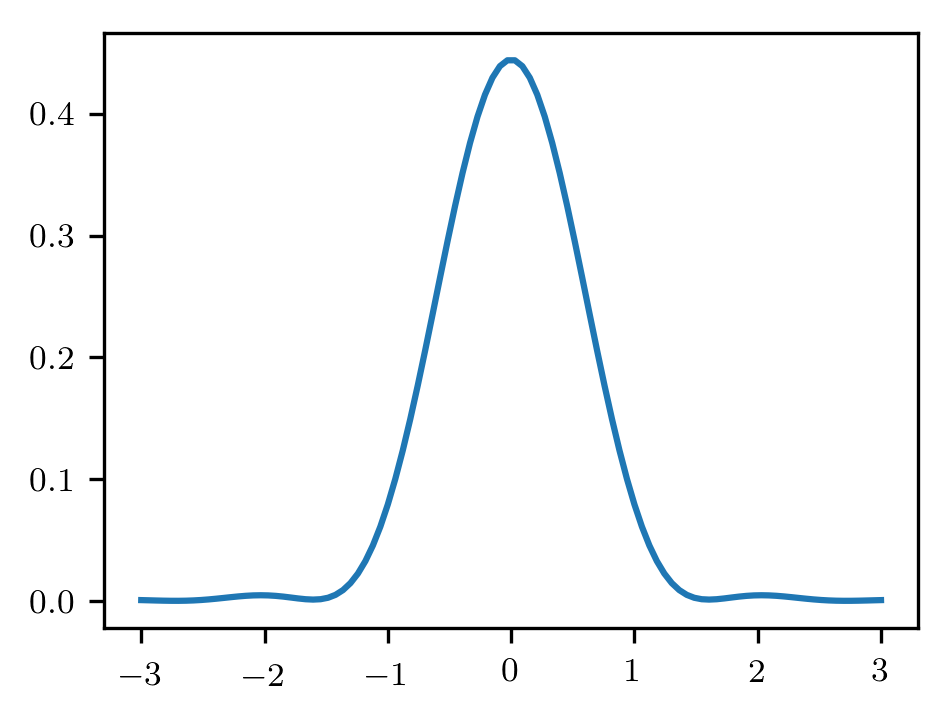

In [121]:
xs = np.linspace(-3,3, 100)
plt.plot(xs, np.sum(elec(0, xs, 0, 3)**2., axis=0))

In [122]:
def dot(field1, field2):
    return np.sum(field1 * field2, axis=0)

def dip_image(
    T1, T2, w, l, d, b1, b2, a1, a2, 
    pp1_func,
    pp2_func,
#     dip_angle_1=0,
#     dip_angle_2=0,
    gScale=1,
    n_b=n0,
    return_components=False):

    k = w*n_b/c
    x1 = l + d/2
    x2 = l - d/2
    
    field1 = elec(0, x1, 0, k)
    field2 = elec(0, x2, 0, k)
    
    pp1 = pp1_func(
        w, T1, b1, T2, b2, d, a1, a2, 
        gScale=1
        )
    pp2 = pp2_func(
        w, T1, b1, T2, b2, d, a1, a2, 
        gScale=1
        )
    
    t1 = np.abs(pp1)**2. * dot(field1, np.conj(field1))
    t2 = np.abs(pp2)**2. * dot(field2, np.conj(field2))
    t3 = (
        np.abs(pp1)*np.abs(pp2)
        *
        2*np.real(dot(field1, np.conj(field2)))
        * 
        np.cos(
            np.arctan2(np.imag(pp1), np.real(pp1))
            - 
            np.arctan2(np.imag(pp2), np.real(pp2))
            )
        )

    if not return_components:
        return t1 + t2 + t3
    elif return_components:
        return np.array([t1, t2, t3])
    else: print('what?...')


def hot_I(
    T1, T2, w, l, d, b1, b2, a1, a2, 
#     dip_angle_1=0,
#     dip_angle_2=0,
    gScale=1,
    **kwargs):

#     print(f'kwargs = {kwargs}')
    image = dip_image(
        T1, T2, w, l, d, b1, b2, a1, a2, 
        pp1_func=p1hotFoc,
        pp2_func=p2hotFoc,
        **kwargs,
#         dip_angle_1=dip_angle_1,
#         dip_angle_2=dip_angle_2,
        )
    
    return image


def cold_I(
    T1, T2, w, l, d, b1, b2, a1, a2, 
#     dip_angle_1=0,
#     dip_angle_2=0,
    **kwargs):

    image = dip_image(
        T1, T2, w, l, d, b1, b2, a1, a2, 
        pp1_func=p1coldFoc,
        pp2_func=p2coldFoc,
        **kwargs,
#         dip_angle_1=dip_angle_1,
#         dip_angle_2=dip_angle_2,
        )
    
    return image

    
def wfi_pti(T1, T2, w, l, d, b1, b2, a1, a2, 
#     dip_angle_1=0,
#     dip_angle_2=0,
    **kwargs):
    """ Lengths are input in nm 
        
        Args:
            T1: Temperature of particle 1 (core)
            T2: Temperature of particle 2 (core)
            w: frequency of probe field
            l: x positions to evaluate signal
            d: seperation between particle center points 
            b1: radius of shell surface of particle 1
            b2: radius of shell surface of particle 2
            a1: radius of core of particle 1
            a2: radius of core of particle 2
        """
    
    ## Convert all length args back to cgs (in nm)
    l, d, b1, b2, a1, a2 =  1e-7*np.array([l, d, b1, b2, a1, a2])
    

    difference_I = (
        hot_I(
            T1, T2, w, l, d, b1, b2, a1, a2, 
        #     dip_angle_1=0,
        #     dip_angle_2=0,
            **kwargs)
        -
        cold_I(
            T1, T2, w, l, d, b1, b2, a1, a2, 
        #     dip_angle_1=0,
        #     dip_angle_2=0,
            **kwargs)
        )
    
    return difference_I



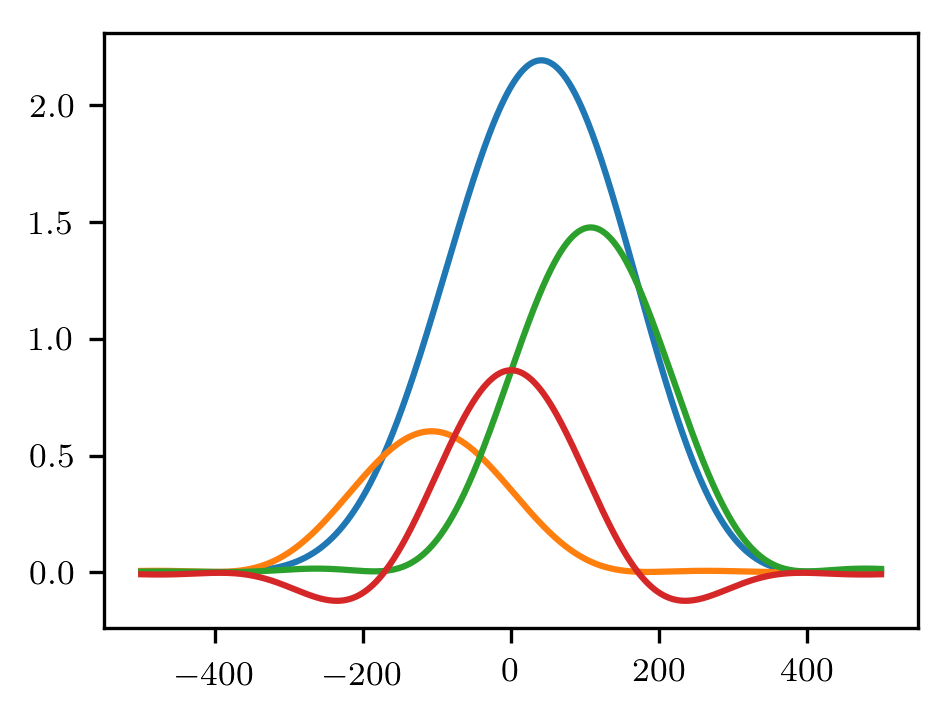

In [123]:
## Define some test parameters

T1 = 15
T2 = 12

a1 = 37
a2 = 44

del_d = 134
del_b1 = 5
del_b2 = 5

d = a1 + del_d + a2
b1 = del_b1 + a1
b2 = del_b2 + a2

hw = 2.2
sensorsize_nm = 1000

xs = np.linspace(-sensorsize_nm/2, sensorsize_nm/2, 1000)

test_image = wfi_pti(T1, T2, hw/hbar, xs, d, b1, b2, a1, a2, 
#     dip_angle_1=0,
#     dip_angle_2=0,
    gScale=1)
test_image_comps = wfi_pti(
    T1, T2, hw/hbar, xs, d, b1, b2, a1, a2, 
#     dip_angle_1=0,
#     dip_angle_2=0,
    gScale=1,
    return_components=True)

# test_image

plt.plot(xs,test_image)

for comp in test_image_comps:
    plt.plot(xs, comp)

## Scan 

In [124]:
def p_gau_probed(
    x_beam,
    x_dip,
    x_that_dip,
    w, T1, b1, T2, b2, d, a1, a2, 
    alpha, that_alpha,
    gscale=1,
    probe_E=Eplane,
    n_b=n0):
    """ Define dipole magnitude with Gaussian beam driving 
        force.
        """
    k = w*n_b/c
    
    this_probe_E = elec(
        0, 
        x=x_dip-x_beam,
        y=0, 
        k=k
        )[0]
    that_probe_E = elec(
        0, 
        x=x_that_dip-x_beam,
        y=0, 
        k=k
        )[0]
#     print(f'that_probe_E = {that_probe_E}')
#     print(f'alpha.shape = {alpha.shape}')
#     print(f'g(0, d, w, gscale).shape = {g(0, d, w, gscale).shape}')
    p = (
        alpha*(
            this_probe_E 
            + g(0, d, w, gscale)*that_alpha*that_probe_E
            )
        /
        (1 - alpha*that_alpha*g(0, d, w, gscale)**2)
        ) 
    
    if len(p.ravel()) is 1:
        p = p.ravel()
    
    return p

In [125]:
p_coupled(
    w=1, T1=1, b1=1, T2=1, b2=1, d=1, a1=1, a2=1, 
    alpha=1, other_alpha=1,)

array([-1.20183194e+17-0.j])

Test return shape of p with multiple beam points

In [126]:
p_gau_probed(
    x_beam=np.linspace(1,3,5),
    x_dip=1,
    x_that_dip=1,
    w=1, T1=1, b1=1, T2=1, b2=1, d=1, a1=1, a2=1, 
    alpha=1, that_alpha=1,
    gscale=1,
    probe_E=Eplane,
    n_b=n0)

/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/gitted/misloc_mispol_package/optics/anal_foc_diff_fields.py:38: RuntimeWarning: invalid value encountered in true_divide
  np.nan_to_num(spf.spherical_jn( 1, k*rho(xi, y) )/(k*rho(xi, y)))
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/gitted/misloc_mispol_package/optics/anal_foc_diff_fields.py:58: RuntimeWarning: invalid value encountered in true_divide
  spf.jv(2, k*rho(xi, y) )/(k*rho(xi, y))


array([-5.99903913e-32-0.j, -6.66666667e-01-0.j, -6.66666667e-01-0.j,
       -6.66666667e-01-0.j, -6.66666667e-01-0.j])

Looks good

### Next build the hot and room temp dipoles

In [127]:
def p1hot_conf(
    x_beam,
    w, T1, b1, T2, b2, d, a1, a2, 
    gscale=1,
    **kwargs):
    """ Confocally probed dipole 1"""
    
    alpha1 = alpha_of_T(T1, b1, a1) 

    alpha2 = alpha_of_T(T2, b2, a2)     
    
    p1 = p_gau_probed(
        x_beam, 
        x_dip=-d/2, 
        x_that_dip=+d/2,
        w=w,
        T1=T1,
        b1=b1,
        T2=T2,
        b2=b2,
        d=d,
        a1=a1,
        a2=a2,
        alpha=alpha1, 
        that_alpha=alpha2,
        gscale=gscale)

    return p1


def p2hot_conf(
    x_beam,
    w, T1, b1, T2, b2, d, a1, a2, 
    gscale=1,
    **kwargs):
    
    alpha1 = alpha_of_T(T1, b1, a1) 

    alpha2 = alpha_of_T(T2, b2, a2)     
    
    p2 = p_gau_probed(
        x_beam, 
        x_dip=+d/2, 
        x_that_dip=-d/2,
        w=w,
        T1=T1,
        b1=b1,
        T2=T2,
        b2=b2,
        d=d,
        a1=a1,
        a2=a2,
        alpha=alpha2, 
        that_alpha=alpha1,
        gscale=gscale)

    return p2


def p1cold_conf(
    x_beam,
    w, T1, b1, T2, b2, d, a1, a2, 
    gscale=1,
    **kwargs):
    
    alpha1 = alphaC(a1) 

    alpha2 = alphaC(a2)     
    
    p1 = p_gau_probed(
        x_beam, 
        x_dip=-d/2, 
        x_that_dip=+d/2,
        w=w,
        T1=T1,
        b1=b1,
        T2=T2,
        b2=b2,
        d=d,
        a1=a1,
        a2=a2,
        alpha=alpha1, 
        that_alpha=alpha2,
        gscale=gscale)

    return p1


def p2cold_conf(
    x_beam,
    w, T1, b1, T2, b2, d, a1, a2, 
    gscale=1,
    **kwargs):
    
    alpha1 = alphaC(a1) 

    alpha2 = alphaC(a2)     
    
    p2 = p_gau_probed(
        x_beam, 
        x_dip=+d/2, 
        x_that_dip=-d/2,
        w=w,
        T1=T1,
        b1=b1,
        T2=T2,
        b2=b2,
        d=d,
        a1=a1,
        a2=a2,
        alpha=alpha2, 
        that_alpha=alpha1,
        gscale=gscale)

    return p2

## And nor build the scattered power expressions
def power_scatt_two_dips(
    p1, p2,
    x_beam,
    w, T1, b1, T2, b2, d, a1, a2,
    return_components=False, 
    gscale=1):
    """ With interference contributions a la Draine """
    
    t1 = (1/3)*(w**4./c**3.)*np.abs(p1)**2.
    t2 = (1/3)*(w**4./c**3.)*np.abs(p2)**2.
    t3 = w*np.imag(g(0, d, w, gscale))*np.real(p1*np.conj(p2))
    
    if not return_components:
        return t1 + t2 + t3
    elif return_components:
        return np.array([t1, t2, t3])


def conf_PTI(
    x_beam,
    w, T1, b1, T2, b2, d, a1, a2,
    **kwargs):
    
    x_beam, d, b1, b2, a1, a2 =  1e-7*np.array([x_beam, d, b1, b2, a1, a2])
    
    p1_hot = p1hot_conf(x_beam, w, T1, b1, T2, b2, d, a1, a2, **kwargs)
    p2_hot = p2hot_conf(x_beam, w, T1, b1, T2, b2, d, a1, a2, **kwargs) 
    
    p1_cold = p1cold_conf(x_beam, w, T1, b1, T2, b2, d, a1, a2, **kwargs) 
    p2_cold = p2cold_conf(x_beam, w, T1, b1, T2, b2, d, a1, a2, **kwargs) 
    
    hot_signal = power_scatt_two_dips(
        p1_hot, 
        p2_hot,
        x_beam,
        w, T1, b1, T2, b2, d, a1, a2, **kwargs)
    
    cold_signal = power_scatt_two_dips(
        p1_cold, 
        p2_cold,
        x_beam,
        w, T1, b1, T2, b2, d, a1, a2, **kwargs)
    
    return hot_signal - cold_signal


        

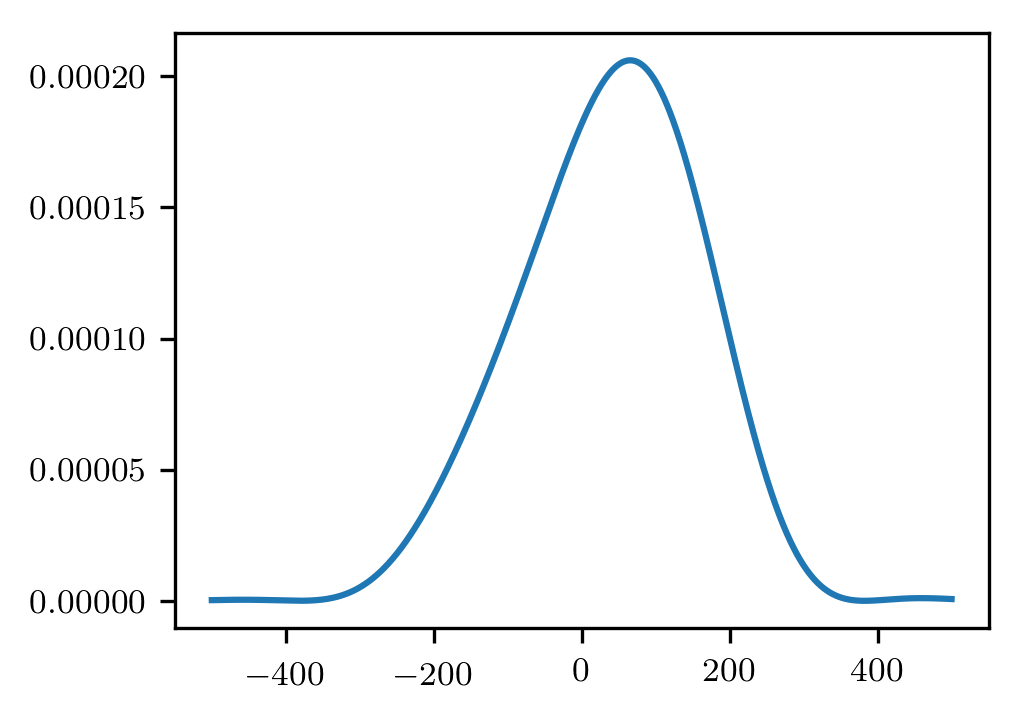

In [128]:
plt.plot(xs, conf_PTI(xs, hw/hbar, T1, b1, T2, b2, d, a1, a2,))

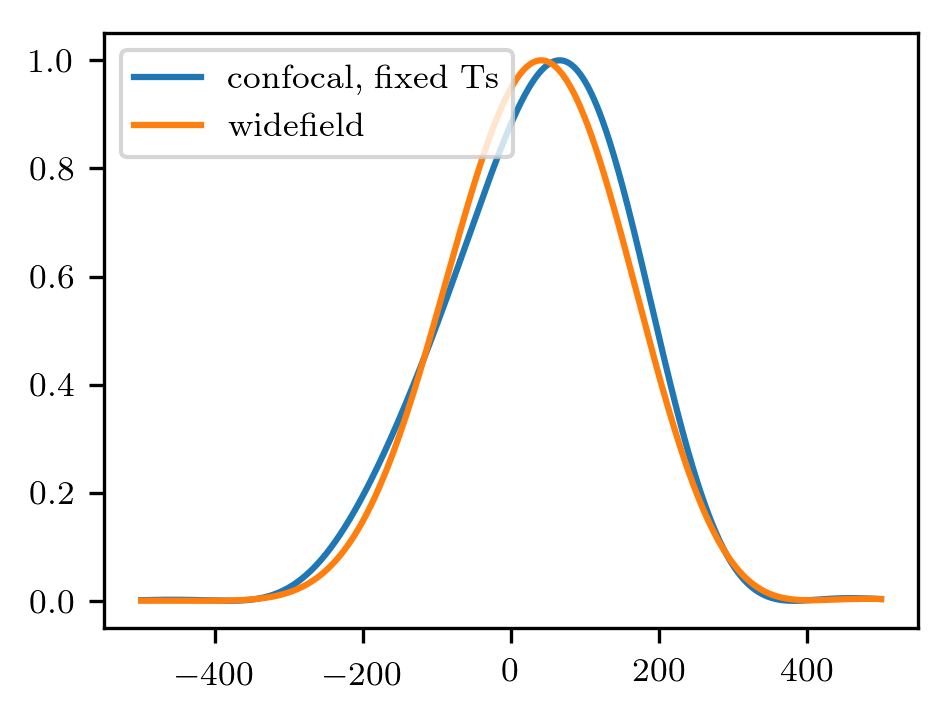

In [129]:
norm_cf = conf_PTI(xs, hw/hbar, T1, b1, T2, b2, d, a1, a2,)
norm_cf /= norm_cf.max()
plt.plot(
    xs, 
    norm_cf,
    label='confocal, fixed Ts'
    )

norm_wf = wfi_pti(T1, T2, hw/hbar, xs, d, b1, b2, a1, a2,)
norm_wf /= norm_wf.max()
plt.plot(
    xs, 
    norm_wf,
    label='widefield',
    ),
plt.legend()

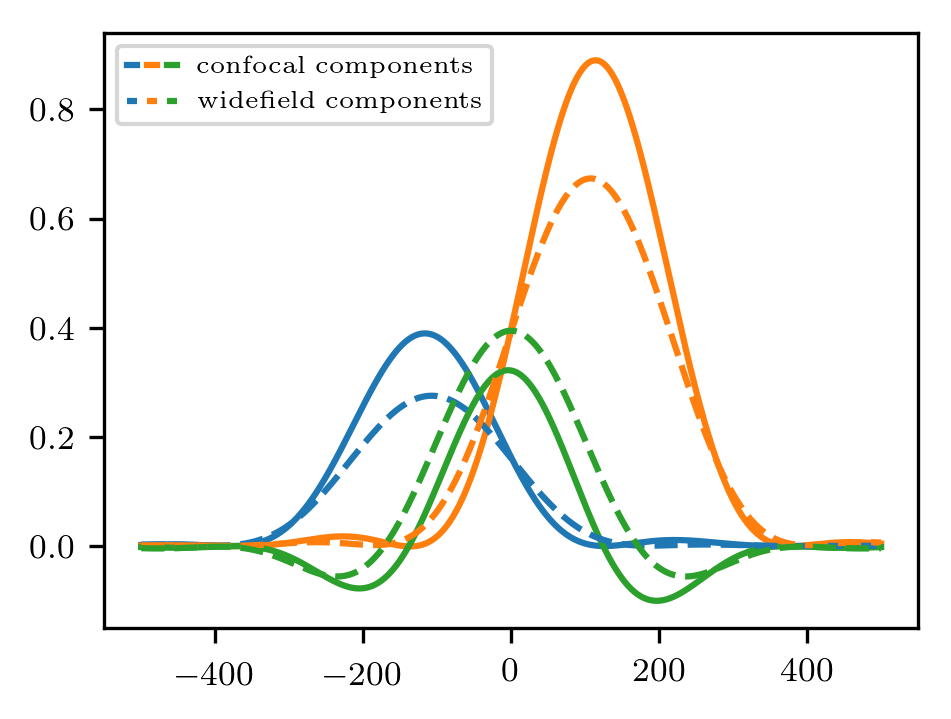

In [130]:
test_cf_image_comps = conf_PTI(
    xs, hw/hbar, T1, b1, T2, b2, d, a1, a2,
    return_components=True)


from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

# with plt.style.context('classic'):
cf_plots = []
for comp in test_cf_image_comps:
    ## Store hadle for legend
    plot, = plt.plot(
        xs, 
        comp/conf_PTI(xs, hw/hbar, T1, b1, T2, b2, d, a1, a2,).max())
    
    cf_plots.append(plot)
    

## Plot wf components on top
plt.gca().set_prop_cycle(None)
wf_plots = []
for comp in test_image_comps:
    plot, = plt.plot(
        xs, 
        comp/wfi_pti(T1, T2, hw/hbar, xs, d, b1, b2, a1, a2,).max(),
        ls='--')
    wf_plots.append(plot)
    
l = plt.legend(
    [tuple(cf_plots), tuple(wf_plots)], 
    ['confocal components', 'widefield components'], 
    fontsize=6,
    numpoints=1,
   handler_map={tuple: HandlerTuple(ndivide=None)})
    

### Setting temperatures from calculations

In [131]:
seperations = np.array([5, 10, 15, 20, 25, 50, 75])

## Get temperatures from plot in Orcas poster

a_1 = 10
particle_1_temps = np.array([51, 40, 34, 32, 28, 23, 20])

a_2 = 15
particle_2_temps = np.array([46, 43, 42, 41, 40, 38, 37])

## Set one drive energy for all of them as a first go
hw_drive = 1240/550

## Set shell radii
b_1 = a_1 + 5
b_2 = a_2 + 5
## Maybe should give the shells equal volume, I should see how that 
## changes things.

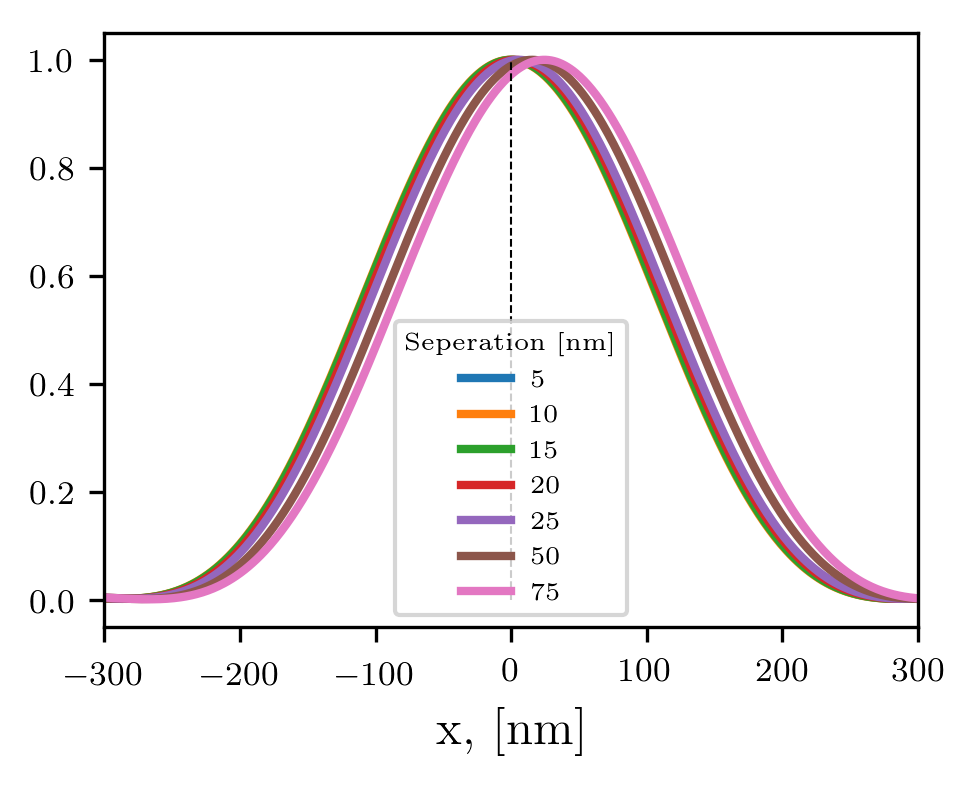

In [150]:
## make plots 
for i in range(len(seperations)):

    wf_image = wfi_pti(
        T1=particle_1_temps[i],
        T2=particle_2_temps[i],
        w=hw_drive/hbar,
        l=xs,
        d=seperations[i],
        b1=b_1,
        b2=b_2,
        a1=a_1,
        a2=a_2)
    
    wf_image /= wf_image.max()
    
    plt.plot(xs, wf_image, lw=2, label=f'{seperations[i]:d}')
    
## Reset color cycler and change shell size
plt.gca().set_prop_cycle(None)
    
# for i in range(len(seperations)):

#     wf_image = wfi_pti(
#         T1=particle_1_temps[i],
#         T2=particle_2_temps[i],
#         w=hw_drive/hbar,
#         l=xs,
#         d=seperations[i],
#         b1=b_1+2000,
#         b2=b_2+2000,
#         a1=a_1,
#         a2=a_2)

#     wf_image /= np.abs(wf_image).max()
    
#     plt.plot(xs, wf_image, lw=.5, ls='--', label=f'{seperations[i]:d}')
    
plt.plot([0,0], [0, 1], c='black', ls='--', lw=0.5)

plt.xlim([-300, 300])
plt.xlabel('x, [nm]')

plt.legend(title='Seperation [nm]', fontsize=6, title_fontsize=6)

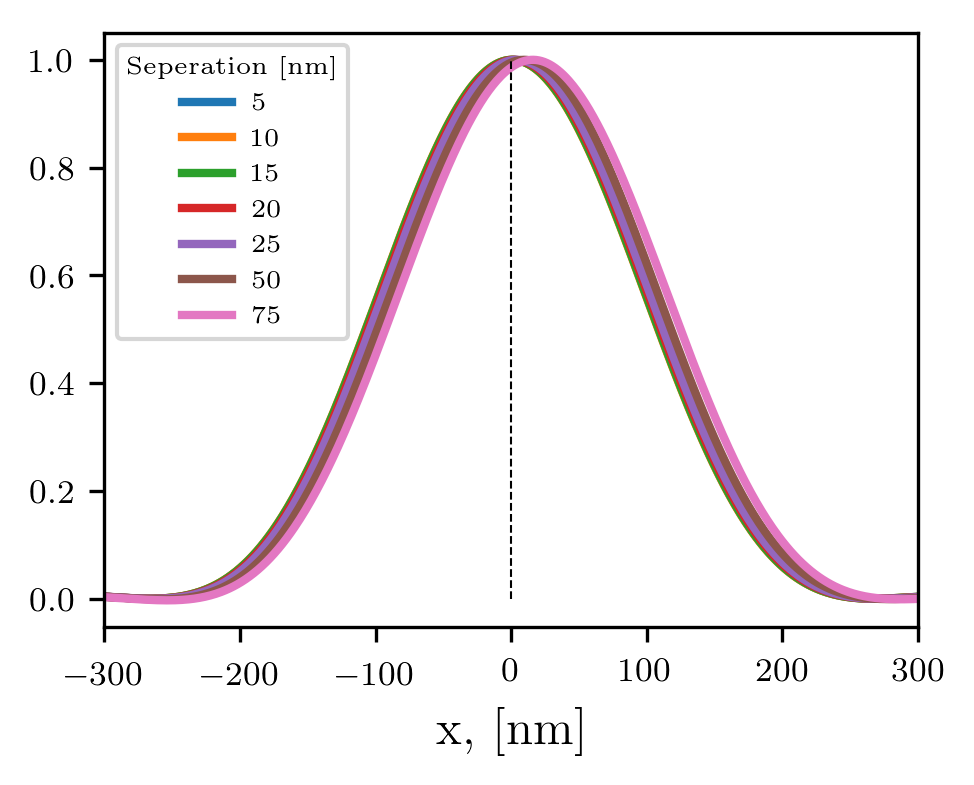

In [151]:
for i in range(len(seperations)):

    cf_image = conf_PTI(
        x_beam=xs,
        w=hw_drive/hbar,
        T1=particle_1_temps[i],
        b1=b_1,
        T2=particle_2_temps[i],
        b2=b_2,
        d=seperations[i],
        a1=a_1,
        a2=a_2,
        )
    
    cf_image /= cf_image.max()
    
    plt.plot(xs, cf_image, lw=2, label=f'{seperations[i]:d}')
    
    
## Plot verticle line at zero for eye guide
plt.plot([0,0], [0, 1], c='black', ls='--', lw=0.5)

plt.xlim([-300, 300])
plt.xlabel('x, [nm]')

plt.legend(title='Seperation [nm]', fontsize=6, title_fontsize=6)





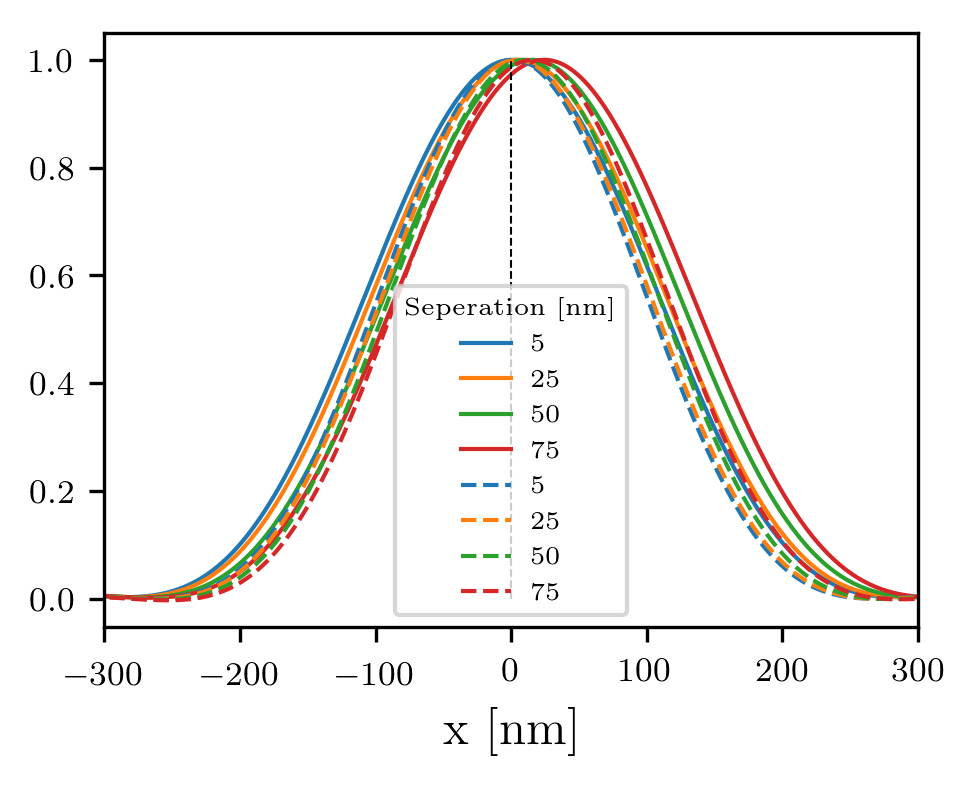

In [161]:
## make plots 

iters = [0, -3, -2, -1]
for i in iters:

    wf_image = wfi_pti(
        T1=particle_1_temps[i],
        T2=particle_2_temps[i],
        w=hw_drive/hbar,
        l=xs,
        d=seperations[i],
        b1=b_1,
        b2=b_2,
        a1=a_1,
        a2=a_2)
    
    wf_image /= wf_image.max()
    
    plt.plot(xs, wf_image, lw=1, label=f'{seperations[i]:d}')
    
## Reset color cycler and change shell size
plt.gca().set_prop_cycle(None)

for i in iters:

    cf_image = conf_PTI(
        x_beam=xs,
        w=hw_drive/hbar,
        T1=particle_1_temps[i],
        b1=b_1,
        T2=particle_2_temps[i],
        b2=b_2,
        d=seperations[i],
        a1=a_1,
        a2=a_2,
        )
    
    cf_image /= cf_image.max()
    
    plt.plot(xs, cf_image, lw=1, ls='--', label=f'{seperations[i]:d}')
    
plt.plot([0,0], [0, 1], c='black', ls='--', lw=0.5)

plt.xlim([-300, 300])
plt.xlabel('x [nm]')

plt.legend(title='Seperation [nm]', fontsize=6, title_fontsize=6)

Thinking about how best to present this... 